In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, make_scorer
warnings.filterwarnings(action='ignore')

### 결측치 처리에 대한 거는 저번에 올려둔 코드 보면 됨
#### 이 코드는 결측치 처리 이후 전처리 +모델링 과정

In [3]:
df=pd.read_csv("secom_final.csv").drop("Unnamed: 0",axis=1)


FileNotFoundError: [Errno 2] File secom_final.csv does not exist: 'secom_final.csv'

In [ ]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

### 다중공선성 방지해주기 위해서 독립변수 간 상관관계가 0.9 이상인 feature pair 중에 하나 제거

변수 450->251개로 줄었음.


In [ ]:
df_corrdel = remove_collinear_features(df,0.9)

In [ ]:
df_final=df_corrdel.copy()

## outlier 처리
### 1. 이상치 처리 전, 테스트 데이터는 따로 분리해놓음.
### 이유: 이상치 처리를 한 후, 테스트 데이터를 나누게 되면 이미 테스트 데이터가 전처리 과정에서 사용된 것이기 때문에 잘못된 전처리 방법이 된다. -> 대본에 적어놓고 언급 ㄱ ㄱ
### feature selection도 마찬가지임!

### 2. 트레인 데이터에서 클래스 별(Pass, Fail)로 데이터 셋을 나눈 후, isolation forest 알고리즘을 사용하여 각각의 Pass 데이터 분포, Fail 데이터 분포에  따르지 않는 index들을 분석에 악영향을 주는 노이즈라고 취급하고 제거(각 1% ) 

### 3. 각각 정규화 후 3차원 PCA 사용하여 시각화함.

In [ ]:
class_weight=len(df_final[df_final["Pass/Fail"]==1])/len(df_final[df_final["Pass/Fail"]==0])

In [ ]:
y = df_final['Pass/Fail']
X1 = df_final.drop('Pass/Fail',axis=1)

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y,test_size = 0.2, random_state = 12, stratify = y)

In [ ]:
train=pd.concat([X1_train,y1_train],axis=1)

In [ ]:
train_Pass=train[train['Pass/Fail']==0].drop("Pass/Fail",axis=1)
train_Fail=train[train["Pass/Fail"]==1].drop("Pass/Fail",axis=1)
train_Pass=train_Pass.reset_index()
train_Pass.drop('index',axis=1,inplace=True)
train_Fail=train_Fail.reset_index()
train_Fail.drop('index',axis=1,inplace=True)

In [ ]:
from sklearn.ensemble import IsolationForest
clf1=IsolationForest(n_estimators=50, max_samples=len(train_Pass), contamination=0.0116, 
                        max_features=0.9, bootstrap=False, n_jobs=-1, random_state=1, verbose=0,behaviour="new")
# %의 outlier 색출.
clf1.fit(train_Pass)
pred = clf1.predict(train_Pass)
train_Pass['anomaly']=pred
outliers_pass=train_Pass.loc[train_Pass['anomaly']==-1]
outlier_index_pass=list(outliers_pass.index)
print(outlier_index_pass)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(train_Pass['anomaly'].value_counts())

[36, 74, 90, 183, 191, 194, 362, 509, 524, 588, 781, 932, 956, 1049]
 1    1156
-1      14
Name: anomaly, dtype: int64


In [ ]:
from sklearn.ensemble import IsolationForest
clf1=IsolationForest(n_estimators=50, max_samples=len(train_Fail), contamination=0.009, 
                        max_features=0.9, bootstrap=False, n_jobs=-1, random_state=1, verbose=0,behaviour="new")
# %의 outlier 색출.
clf1.fit(train_Fail)
pred = clf1.predict(train_Fail)
train_Fail['anomaly']=pred
outliers_fail=train_Fail.loc[train_Fail['anomaly']==-1]
outlier_index_fail=list(outliers_fail.index)
print(outlier_index_fail)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(train_Fail['anomaly'].value_counts())

[38]
 1    82
-1     1
Name: anomaly, dtype: int64


In [ ]:
train_Pass_1=train_Pass[train_Pass['anomaly']==1].drop("anomaly",axis=1)
train_Pass_1["Pass/Fail"]=0
train_Fail_1=train_Fail[train_Fail['anomaly']==1].drop("anomaly",axis=1)
train_Fail_1["Pass/Fail"]=1
train_1=pd.concat([train_Pass_1,train_Fail_1],axis=0)
y1_train =train_1['Pass/Fail']
X1_train = train_1.drop('Pass/Fail',axis=1)

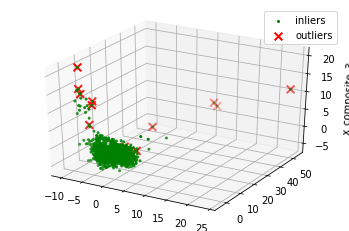

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3) 
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(train_Pass)
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index_pass,0],X_reduce[outlier_index_pass,1], X_reduce[outlier_index_pass,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

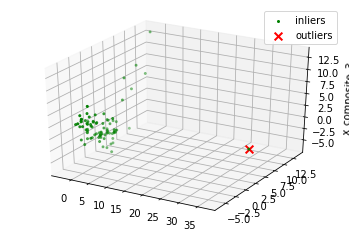

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3) 
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(train_Fail)
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index_fail,0],X_reduce[outlier_index_fail,1], X_reduce[outlier_index_fail,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()


## feature selection 으로 변수 52개만 남김

In [ ]:
pip install eli5

     |████████████████████████████████| 112kB 4.3MB/s 


In [ ]:
import eli5 
from eli5.sklearn import PermutationImportance 
from sklearn.ensemble import RandomForestClassifier


# 미리 사용할 알고리즘을 fit 해야한다
model = RandomForestClassifier(n_estimators =80,random_state=12).fit(X1_train, y1_train)
perm = PermutationImportance(model, scoring = "f1", random_state = 12).fit(X1_train, y1_train) 


In [ ]:
temp=eli5.explain_weights_df(perm)

In [ ]:
important_cols_p=temp[temp['weight']>0]['feature'].map(lambda x: int(x.replace('x', ''))).values
important_cols_p

important_cols_p=X1_train.columns[important_cols_p].values

In [ ]:
df_final_2 = pd.concat([df_final[important_cols_p],df_final['Pass/Fail']],axis= 1)
y = df_final_2['Pass/Fail']
X2 = df_final_2.drop('Pass/Fail',axis=1)

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y,test_size = 0.2, random_state = 12, stratify = y)
X2_train.reset_index(inplace=True)
X2_test.reset_index(inplace=True)

In [ ]:
X2_train.drop("index",axis=1,inplace=True)
X2_test.drop("index",axis=1,inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
#X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y,test_size = 0.2, random_state = 12, stratify = y)
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100,random_state=12),threshold=0.005)
sel.fit(X1_train, y1_train)
selected_feat= X1_train.columns[(sel.get_support())]
df_final_fs = pd.concat([df_final[selected_feat],df_final['Pass/Fail']],axis= 1)
y = df_final_fs['Pass/Fail']
X1 = df_final_fs.drop('Pass/Fail',axis=1)

In [ ]:
unique_vals = df_final_2['Pass/Fail'].unique()  # [0, 1, 2]
targets = [df_final_2.loc[df_final_fs['Pass/Fail'] == val] for val in unique_vals]

In [ ]:
X_temp = pd.concat([X2_train,y2_train],axis= 1)

## SMOTE

SMOTE는 소수 클래스(Fail)에서 각 샘플의 knn을 찾아서 이웃과 이은 선에서 새로운 점을 무작위로 생성한다.

이러면 샘플들 사이의 특성을 반영한 데이터를 생성할 수 있다.

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=12)
# train 데이터에서 오버샘플링 시키기
x_train_over, y_train_over = smote.fit_sample(X2_train, y2_train)

# 오버샘플링 적용 후 데이터 레이블 개수 살펴보기
print('오버샘플링 전 :', X2_train.shape, y2_train.shape)
print()
print('오버샘플링 후 :', x_train_over.shape, y_train_over.shape)
print()
print('오버샘플링 전 레이블 분포 :\n', pd.Series(y2_train).value_counts())
print()
print('오버샘플링 후 레이블 분포 :\n', pd.Series(y_train_over).value_counts())

오버샘플링 전 : (1253, 42) (1253,)

오버샘플링 후 : (2340, 42) (2340,)

오버샘플링 전 레이블 분포 :
 0    1170
1      83
Name: Pass/Fail, dtype: int64

오버샘플링 후 레이블 분포 :
 1    1170
0    1170
dtype: int64


Class=0, n=1170 (74.665%)
Class=1, n=83 (5.297%)


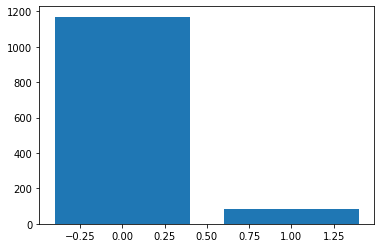

In [ ]:
from collections import Counter
from matplotlib import pyplot

counter = Counter(y2_train)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
 
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

Class=0, n=1170 (74.665%)
Class=1, n=1170 (74.665%)


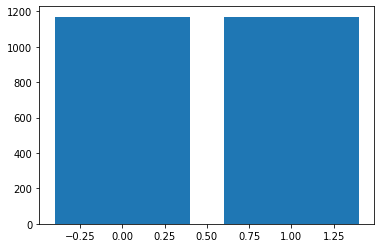

In [ ]:
from collections import Counter
from matplotlib import pyplot

counter = Counter(y_train_over)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
 
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

## ADASYN 

SMOTE의 개선된 버전이다. 동일한 프로세스를 진행한 후 점들에 임의의 작은 값을 더해줌으로써 조금 더 사실적인 데이터가 생성된다. 즉 모든 표본이 약간 더 분산된다.



In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import ADASYN # doctest: +NORMALIZE_WHITESPACE

print('Original dataset shape %s' % Counter(y2_train))

ada = ADASYN(random_state=12)
X_res, y_res = ada.fit_sample(X2_train, y2_train)
print('Resampled dataset shape %s' % Counter(y_res))

print('오버샘플링 전 :', X2_train.shape, y2_train.shape)
print()
print('오버샘플링 후 :', X_res.shape, y_res.shape)
print()
print('오버샘플링 전 레이블 분포 :\n', pd.Series(y2_train).value_counts())
print()
print('오버샘플링 후 레이블 분포 :\n', pd.Series(y_res).value_counts())

Original dataset shape Counter({0: 1170, 1: 83})
Resampled dataset shape Counter({1: 1185, 0: 1170})
오버샘플링 전 : (1253, 42) (1253,)

오버샘플링 후 : (2355, 42) (2355,)

오버샘플링 전 레이블 분포 :
 0    1170
1      83
Name: Pass/Fail, dtype: int64

오버샘플링 후 레이블 분포 :
 1    1185
0    1170
dtype: int64
